In [264]:
import skimage
import skimage.filters
from pathlib import Path
import io3d
from matplotlib import pyplot as plt
import scipy
import exsu
from skimage.morphology import label
from scipy.ndimage.morphology import binary_closing, binary_erosion, binary_opening, binary_dilation
from skimage.color import label2rgb
from skimage.measure import regionprops
import pandas as pd

In [3]:
pth = io3d.joinp("medical/orig/cardio_blood_cells/TP1_a")

In [4]:
pth.exists()

True

# Segmentation processing step by step

In [8]:
# for fn in pth.glob("*.jpg"):
fn = list(pth.glob("*jpg"))[0]
    

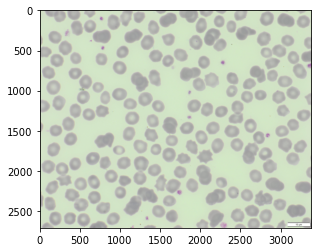

In [13]:
im = skimage.io.imread(fn)
plt.imshow(im)

In [47]:
report = exsu.Report("report", show=True)
debug = True

def show_if_debug(*args, debug=True, show_colorbar=False, **kwargs):
    if debug:
        plt.figure()
        plt.imshow(*args, **kwargs)
        if show_colorbar:
            plt.colorbar()

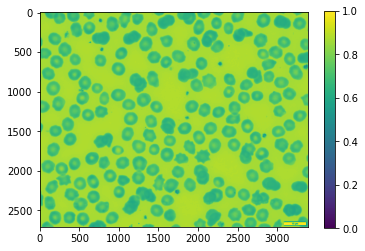

In [79]:
img = skimage.color.rgb2gray(im)
show_if_debug(img, debug=debug, show_colorbar=True)

In [96]:
threshold = skimage.filters.threshold_otsu(img[:])

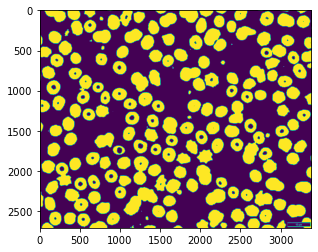

In [97]:
bim = img < threshold
show_if_debug(bim, debug=debug)

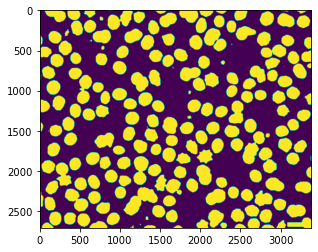

In [98]:
bim = scipy.ndimage.binary_fill_holes(bim)
show_if_debug(bim, debug=debug)

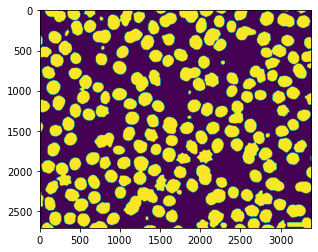

In [99]:
bim = skimage.morphology.remove_small_objects(bim, min_size=1000)
show_if_debug(bim, debug=debug)

In [105]:
# imlabel = label(bim, background=0)
# imrgb = label2rgb(imlabel, image=img)
# show_if_debug(imrgb)

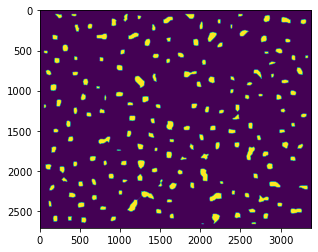

In [110]:
bimd = binary_erosion(bim,iterations=50)
bimd[-100:,-500:] = 0  # remove size tag
show_if_debug(bimd, debug=debug)

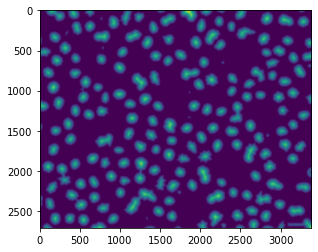

In [107]:
distance = scipy.ndimage.distance_transform_edt(bim)
show_if_debug(distance, debug=debug)


C:\Users\Jirik\Miniconda3\envs\lisa3qt5\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


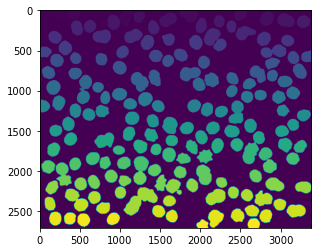

In [114]:
imlabel = skimage.morphology.watershed(-distance, markers=label(bimd), mask=bim)
show_if_debug(imlabel, debug=debug)

## Segmented cells

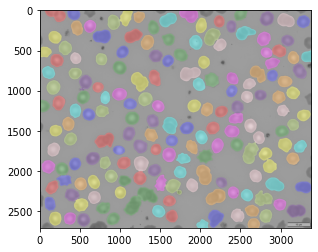

In [115]:
imrgb = label2rgb(imlabel, image=img, bg_label=0)
show_if_debug(imrgb)

# Cell shape description

In [116]:
from sklearn import datasets
import numpy as np
import sklearn.model_selection 

In [270]:
features = []
cls = []
i = 0
for props in regionprops(imlabel, intensity_image=img):
    feature = [
        props.area,
        (props.perimeter**2) / props.area,
        props.perimeter,
        props.max_intensity,
        props.mean_intensity,
        props.min_intensity
    ]
    features.append(feature)
    if props.area < 0.9e4:
        y = 0
        
    elif props.area > 2.5e4:
        y = 1
    else:

        # normal size
        if (props.perimeter**2) / props.area < 15.5:
            y = 2
        else:
            y = 3

    
    cls.append(y)
    i += 1


cls = np.array(cls)
vals, co = np.unique(cls, return_counts=True)
vals, co

(array([0, 1, 2, 3]), array([  1,  23, 122,  22], dtype=int64))

In [271]:
# ids = np.array(list(range(np.max(imlabel))))
# cls[ids==1]
imlabel_types = np.zeros_like(imlabel)
for i in range(1, np.max(imlabel)):
    imlabel_types[imlabel==i] = cls[i-1] + 1

In [272]:
features = np.array(features)

df = pd.DataFrame({
    "Area" : features[:,0],
    "Non-compactness": features[:,1],
    "Perimeter": features[:,2],
    "Max intensity": features[:,3],
    "Mean intensity": features[:,4],
    "Min intensity": features[:,5],
}
)
df

,Area,Non-compactness,Perimeter,Max intensity,Mean intensity,Min intensity
0,26684.0,19.995833,730.457936,0.779209,0.694136,0.624095
1,16970.0,14.916298,503.119841,0.779277,0.688364,0.629966
2,22792.0,17.792356,636.807179,0.796935,0.721006,0.637244
3,28642.0,17.336228,704.658946,0.779032,0.668586,0.621015
4,17402.0,15.500367,519.362482,0.783191,0.713220,0.626915
...,...,...,...,...,...,...
163,18280.0,14.575233,516.173665,0.779016,0.694428,0.628016
164,19418.0,14.755973,535.286363,0.783756,0.712806,0.645087
165,20741.0,14.905351,556.014285,0.814571,0.700773,0.620984
166,15932.0,14.929499,487.705627,0.779277,0.705365,0.649008


# Classification

* purple overlapps - not classified
* yellow - round blood cells
* magenta - rich-shape cells

Found 122 round cells (yellow) and 22 noncompcate cells (magenta). Igneored 23 objects (purple).


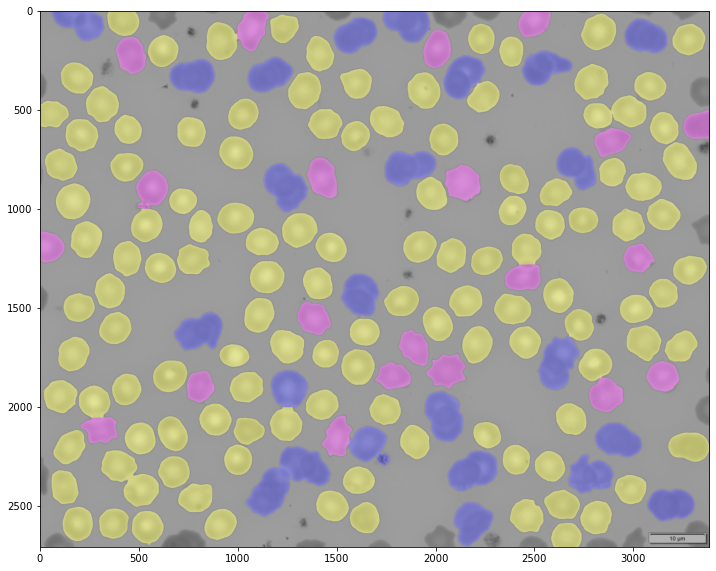

In [275]:
imrgb = label2rgb(imlabel_types, image=img, bg_label=0)
plt.figure(figsize=[12,10])
plt.imshow(imrgb)
print(f"Found {co[2]} round cells (yellow) and {co[3]} noncompcate cells (magenta). Igneored {co[1]} objects (purple).")